# Conditional GAN

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid, save_image
from PIL import Image
import matplotlib.pyplot as plt
import os

## Import dataset with custom loader

In [2]:
img_size = 128
data_path = './Dataset/'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Grayscale(),
    transforms.Resize((img_size,img_size))])

class CustomLoader(torch.utils.data.Dataset):
    def __init__(self, data_path, transform):
        self.path = data_path
        self.files = []
        for dir_path, currentDirectory, dir_files in os.walk(data_path):
            for file in dir_files:
                self.files.append(dir_path + '/' + file)
        self.indices = len(self.files)
        self.transform = transform

    def __getitem__(self, idx):
        image = Image.open(self.files[idx]).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        label = int(self.files[idx].split('-')[0][-1:])

        return image, torch.tensor(label).long()

    def __len__(self):
        return self.indices

transformed_dataset = CustomLoader(data_path, transform)

dataloader = torch.utils.data.DataLoader(transformed_dataset, batch_size=32, shuffle=True)

### Visualise one image

tensor(0)

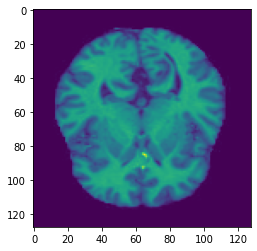

In [3]:
data = CustomLoader(data_path, transform)
im, label = data[3980]
plt.imshow(im.permute(1,2,0).cpu())
label

## Create Model

In [4]:
import numpy as np
from tqdm import trange
from torch.autograd import Variable
import torch.nn as nn
import torch

latent_dim = 100
img_shape = (1, img_size, img_size)

class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(self.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity


class GAN:
    def __init__(self, b1=0.5, b2=0.999, lr=0.0002, latent_dim=100, n_epochs=100):

        self.b1 = b1
        self.b2 = b2
        self.lr = lr
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.cuda = True if torch.cuda.is_available() else False

        self.adversarial_loss = torch.nn.BCELoss()
        self.generator = Generator(latent_dim)
        self.discriminator = Discriminator()
        self.optimizer_G = torch.optim.Adam(self.generator.parameters(), lr=self.lr, betas=(self.b1, self.b2))
        self.optimizer_D = torch.optim.Adam(self.discriminator.parameters(), lr=self.lr, betas=(self.b1, self.b2))

        if self.cuda:
            self.generator.cuda()
            self.discriminator.cuda()
            self.adversarial_loss.cuda()

    def fit(self, dataloader):
        Tensor = torch.cuda.FloatTensor if self.cuda else torch.FloatTensor
        logger = trange(self.n_epochs, desc=f"Epoch: 0, G_Loss: 0, D_Loss: 0")

        for epoch in logger:
            for i, (imgs, _) in enumerate(dataloader):
                valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
                fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)
                real_imgs = Variable(imgs.type(Tensor))

                self.optimizer_G.zero_grad()

                z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], self.latent_dim))))

                gen_imgs = self.generator(z)

                g_loss = self.adversarial_loss(self.discriminator(gen_imgs), valid)

                g_loss.backward()
                self.optimizer_G.step()

                self.optimizer_D.zero_grad()

                real_loss = self.adversarial_loss(self.discriminator(real_imgs), valid)
                fake_loss = self.adversarial_loss(self.discriminator(gen_imgs.detach()), fake)
                d_loss = (real_loss + fake_loss) / 2

                d_loss.backward()
                self.optimizer_D.step()

    def generate(self, n_samples):
        Tensor = torch.cuda.FloatTensor if self.cuda else torch.FloatTensor
        z = Variable(Tensor(np.random.normal(0, 1, (n_samples, self.latent_dim))))
        return self.generator(z)

## Train & Reproduce images

In [5]:
gan = GAN(n_epochs=5)
gan.fit(dataloader)

Epoch: 0, G_Loss: 0, D_Loss: 0: 100%|██████████| 5/5 [02:53<00:00, 34.77s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


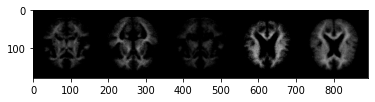

In [6]:
with torch.no_grad():
    grid_img = make_grid(gan.generate(5), nrow=5)
    plt.imshow(grid_img.permute(1,2,0).cpu().detach().numpy())

In [7]:
gan = GAN(n_epochs=20)
gan.fit(dataloader)

Epoch: 0, G_Loss: 0, D_Loss: 0: 100%|██████████| 20/20 [09:35<00:00, 28.76s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


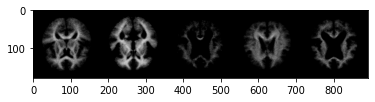

In [8]:
with torch.no_grad():
    grid_img = make_grid(gan.generate(5), nrow=5)
    plt.imshow(grid_img.permute(1,2,0).cpu().detach().numpy())

## Save the model

In [10]:
PATH = "./model/gan/model.pt"

torch.save({
    'generator': gan.generator.state_dict(),
    'discriminator': gan.discriminator.state_dict(),
    'generator_optimizer': gan.optimizer_G.state_dict(),
    'discriminator_optimizer': gan.optimizer_D.state_dict(),
}, PATH)